In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import soundfile as sf

In [2]:
audio_file = "gwtwd.wav"
y, sr = librosa.load(audio_file)

In [3]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T

In [4]:
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs)

In [5]:
cluster_range = range(2, 11)
bic_scores = []
silhouette_scores = []

In [6]:
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(mfccs_scaled)
    bic_scores.append(gmm.bic(mfccs_scaled))
    
    if n_clusters > 1:
        labels = gmm.predict(mfccs_scaled)
        score = silhouette_score(mfccs_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)

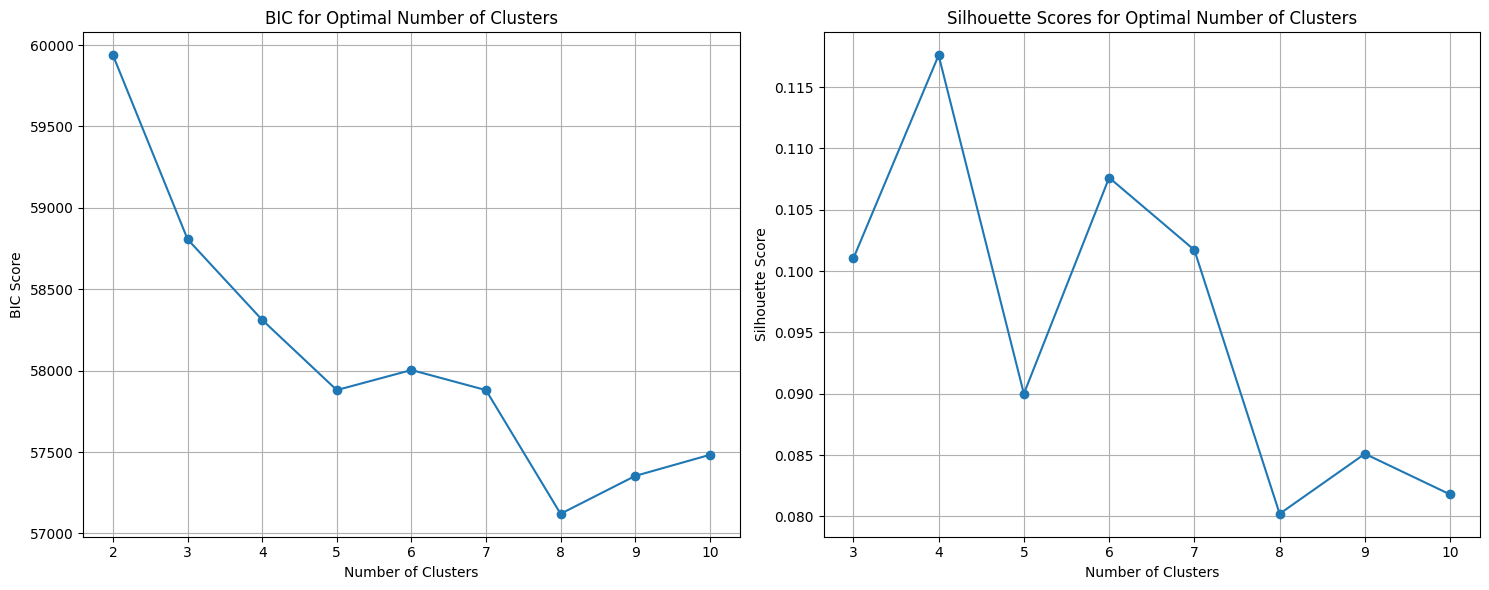

In [7]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, bic_scores, marker='o')
plt.title('BIC for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.xticks(cluster_range)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(cluster_range[1:], silhouette_scores[1:], marker='o')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range[1:])
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]

In [9]:
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(mfccs_scaled)

labels = gmm.predict(mfccs_scaled)

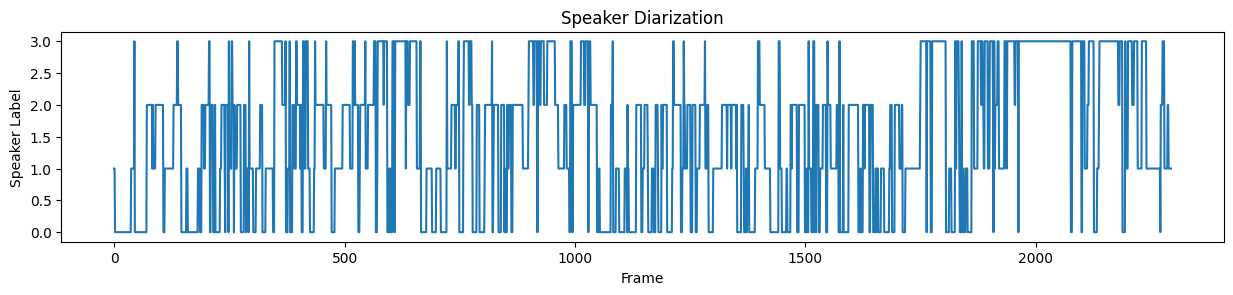

In [10]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 2)
plt.plot(labels)
plt.title('Speaker Diarization')
plt.xlabel('Frame')
plt.ylabel('Speaker Label')
plt.show()

In [11]:
for cluster in range(optimal_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_audio = []
    hop_length = 512
    
    for idx in cluster_indices:
        start_sample = idx * hop_length
        end_sample = (idx + 1) * hop_length
        cluster_audio.append(y[start_sample:end_sample])
    
    cluster_audio = np.concatenate(cluster_audio)
    
    output_file = f'gmm/cluster_{cluster}.wav'
    sf.write(output_file, cluster_audio, sr)
    print(f'Cluster {cluster} audio saved to {output_file}')

Cluster 0 audio saved to gmm/cluster_0.wav
Cluster 1 audio saved to gmm/cluster_1.wav
Cluster 2 audio saved to gmm/cluster_2.wav
Cluster 3 audio saved to gmm/cluster_3.wav
